In [ ]:
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import re
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import KFold

INPUT_DIR = '../inputs/MiddleburyDataset/data/'
OUTPUT_DIR = '../results'

os.makedirs(OUTPUT_DIR, exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

使用设备: mps


In [ ]:
def read_calib_file(calib_file):
    """Read calibration file and extract parameters."""
    with open(calib_file, 'r') as f:
        lines = f.readlines()
    
    params = {}
    
    for line in lines:
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        
        key_value = line.split('=')
        if len(key_value) != 2:
            continue
        
        key, value = key_value
        
        # Handle camera matrix
        if key == 'cam0' or key == 'cam1':
            # Example: cam0=[1733.74 0 792.27; 0 1733.74 541.89; 0 0 1]
            value = value.replace('[', '').replace(']', '')
            matrix_values = []
            for row in value.split(';'):
                if row:
                    row_values = [float(v) for v in row.split()]
                    matrix_values.extend(row_values)
            params[key] = matrix_values
        # Handle other numeric parameters
        else:
            try:
                params[key] = float(value)
            except ValueError:
                params[key] = value
    
    # Ensure basic parameters exist, use default if missing
    if 'width' not in params:
        params['width'] = 1920
    if 'height' not in params:
        params['height'] = 1080
    if 'ndisp' not in params:
        params['ndisp'] = 192
    
    return params

def read_pfm(file):
    """Read PFM file."""
    with open(file, 'rb') as f:
        # Line 1: PF=>RGB (3 channels), Pf=>Greyscale (1 channel)
        header = f.readline().decode('utf-8').rstrip()
        if header == 'PF':
            color = True
        elif header == 'Pf':
            color = False
        else:
            raise Exception('Not a PFM file: ' + file)
        
        # Line 2: dimensions
        dim_match = re.match(r'^(\d+)\s(\d+)\s$', f.readline().decode('utf-8'))
        if dim_match:
            width, height = map(int, dim_match.groups())
        else:
            raise Exception('Malformed PFM header: ' + file)
        
        # Line 3: scale factor (negative for little-endian)
        scale = float(f.readline().decode('utf-8').rstrip())
        if scale < 0:  # little-endian
            endian = '<'
        else:
            endian = '>'  # big-endian
        
        # Data
        data = np.fromfile(f, endian + 'f')
        shape = (height, width, 3) if color else (height, width)
        data = np.reshape(data, shape)
        data = np.flipud(data)  # Flip vertically
        
        return data, scale

In [ ]:
class MiddleburyDataset(Dataset):
    def __init__(self, root_dir, scenes, transform=None, phase='train', target_size=(256, 512)):
        """
        Args:
            root_dir (string): Directory containing all scenes
            scenes (list): List of scene names to include
            transform (callable, optional): Optional transform to be applied on a sample
            phase (str): 'train' or 'test'
            target_size (tuple): Target size (height, width) for resizing
        """
        self.root_dir = root_dir
        self.scenes = scenes
        self.transform = transform
        self.phase = phase
        self.target_size = target_size
        self.samples = []
        
        # Collect all valid samples
        for scene in scenes:
            scene_dir = os.path.join(root_dir, scene)
            
            # Calibration file path
            calib_file = os.path.join(scene_dir, 'calib.txt')
            
            # Default left/right images and disparity
            left_img_path = os.path.join(scene_dir, 'im0.png')
            right_img_path = os.path.join(scene_dir, 'im1.png')
            left_disp_path = os.path.join(scene_dir, 'disp0.pfm')
            
            if os.path.exists(left_img_path) and os.path.exists(right_img_path) and os.path.exists(left_disp_path) and os.path.exists(calib_file):
                # Read calibration info
                calib_params = read_calib_file(calib_file)
                
                self.samples.append({
                    'left_img': left_img_path,
                    'right_img': right_img_path,
                    'left_disp': left_disp_path,
                    'scene': scene,
                    'calib_params': calib_params
                })
                
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Get calibration parameters
        calib_params = sample['calib_params']
        original_width = int(calib_params['width'])
        original_height = int(calib_params['height'])
        max_disp = int(calib_params['ndisp'])
        
        # Load images
        left_img = Image.open(sample['left_img']).convert('RGB')
        right_img = Image.open(sample['right_img']).convert('RGB')
        
        # Apply transform to RGB images
        if self.transform:
            left_img = self.transform(left_img)
            right_img = self.transform(right_img)
        
        # Load disparity map
        disparity, _ = read_pfm(sample['left_disp'])
        disparity = disparity.astype(np.float32)
        
        # Resize disparity map - use bilinear interpolation
        disparity_pil = Image.fromarray(disparity)
        disparity_pil = disparity_pil.resize(self.target_size, Image.BILINEAR)
        disparity = np.array(disparity_pil)
        
        # Disparity scaling factor - based on width ratio
        width_scale = self.target_size[1] / original_width
        disparity = disparity * width_scale
        
        # Convert disparity to tensor
        disparity = torch.from_numpy(disparity)
        
        # Return sample with calibration parameters
        return {
            'left': left_img,
            'right': right_img,
            'disparity': disparity,
            'scene': sample['scene'],
            'calib_params': calib_params,
            'max_disp': max_disp
        }

In [ ]:
def get_data_loaders(root_dir, fold_idx, k=5, batch_size=1):
    """
    Create train and validation data loaders for k-fold cross-validation

    Args:
        root_dir (str): Dataset path
        fold_idx (int): Current fold index (0 to k-1)
        k (int): Number of folds
        batch_size (int): Batch size

    Returns:
        train_loader, val_loader, val_scenes, max_disp
    """
    # List all scenes
    scenes = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
    scenes.sort()  # Ensure consistent order

    print(f"Found {len(scenes)} scenes: {scenes[:5]}...")

    # Set up k-fold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    train_indices = []
    val_indices = []

    for i, (train_idx, val_idx) in enumerate(kf.split(scenes)):
        if i == fold_idx:
            train_indices = train_idx
            val_indices = val_idx
            break

    train_scenes = [scenes[i] for i in train_indices]
    val_scenes = [scenes[i] for i in val_indices]

    print(f"Fold {fold_idx+1}: Train scenes: {len(train_scenes)}, Validation scenes: {len(val_scenes)}")

    # Define transform - specify target size
    target_size = (256, 512)
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = MiddleburyDataset(root_dir, train_scenes, transform=transform, phase='train', target_size=target_size)
    val_dataset = MiddleburyDataset(root_dir, val_scenes, transform=transform, phase='test', target_size=target_size)

    print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

    # Show calibration info for the first scene
    if len(train_dataset) > 0:
        sample = train_dataset[0]
        calib_params = sample['calib_params']
        print(f"Scene '{sample['scene']}' calibration info:")
        print(f"  Original size: {int(calib_params['width'])}x{int(calib_params['height'])}")
        print(f"  Max disparity: {int(calib_params['ndisp'])}")
        print(f"  Disparity range: {calib_params.get('vmin', 'N/A')} - {calib_params.get('vmax', 'N/A')}")
        print(f"  Baseline: {calib_params.get('baseline', 'N/A')} mm")

        # Determine max disparity
        max_disp = int(calib_params['ndisp'])
    else:
        max_disp = 192  # Default

    # Create data loaders - use num_workers=0 to avoid multiprocessing issues
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, val_scenes, max_disp


In [ ]:
def explore_dataset(data_dir):
    """Explore the dataset and visualize a few samples"""
    scenes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    scenes.sort()
    
    print(f"Found {len(scenes)} scenes")
    
    # Randomly select 3 scenes for visualization
    sample_scenes = random.sample(scenes, min(3, len(scenes)))
    
    plt.figure(figsize=(15, 10))
    
    for i, scene in enumerate(sample_scenes):
        scene_dir = os.path.join(data_dir, scene)
        
        # Load left and right images
        left_img = Image.open(os.path.join(scene_dir, 'im0.png'))
        right_img = Image.open(os.path.join(scene_dir, 'im1.png'))
        
        # Load disparity map
        disparity, _ = read_pfm(os.path.join(scene_dir, 'disp0.pfm'))
        
        # Normalize disparity map for visualization
        disparity_normalized = disparity / np.max(disparity)
        
        # Plot images
        plt.subplot(3, 3, i*3+1)
        plt.imshow(left_img)
        plt.title(f'{scene} - Left Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+2)
        plt.imshow(right_img)
        plt.title(f'{scene} - Right Image')
        plt.axis('off')
        
        plt.subplot(3, 3, i*3+3)
        plt.imshow(disparity_normalized, cmap='plasma')
        plt.title(f'{scene} - Disparity Map')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'dataset_samples.png'))
    plt.show()
    
    print(f"Dataset samples saved to {os.path.join(OUTPUT_DIR, 'dataset_samples.png')}")

def visualize_batch(batch, output_dir, prefix="batch"):
    """Visualize samples in a batch"""
    # Process the first sample in the batch
    i = 0
    left_img = batch['left'][i].permute(1, 2, 0).cpu().numpy()
    right_img = batch['right'][i].permute(1, 2, 0).cpu().numpy()
    disp_img = batch['disparity'][i].cpu().numpy()
    scene_name = batch['scene'][i]
    
    # Denormalize images
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    left_img = left_img * std + mean
    right_img = right_img * std + mean
    
    # Clip to [0,1]
    left_img = np.clip(left_img, 0, 1)
    right_img = np.clip(right_img, 0, 1)
    
    # Normalize disparity map
    disp_min = disp_img.min()
    disp_max = disp_img.max()
    if disp_max > disp_min:
        disp_normalized = (disp_img - disp_min) / (disp_max - disp_min)
    else:
        disp_normalized = disp_img
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(left_img)
    plt.title(f'Left Image - {scene_name}')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(right_img)
    plt.title(f'Right Image - {scene_name}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(disp_normalized, cmap='plasma')
    plt.title(f'Disparity Map - {scene_name}')
    plt.colorbar(label='Normalized Disparity')
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{prefix}_{scene_name}.png'))
    plt.close()
    
    print(f"Sample images saved: {os.path.join(output_dir, f'{prefix}_{scene_name}.png')}")

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class FeatureExtraction(nn.Module):
    def __init__(self):
        super(FeatureExtraction, self).__init__()
        self.inplanes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(BasicBlock, 64, 3)
        self.layer2 = self._make_layer(BasicBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 3, stride=2)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        
        return x4

class CostVolume(nn.Module):
    def __init__(self, max_disp=192):
        super(CostVolume, self).__init__()
        self.max_disp = max_disp
        
    def forward(self, left_feature, right_feature):
        B, C, H, W = left_feature.size()
        cost_volume = torch.zeros(B, C*2, self.max_disp//4, H, W, device=left_feature.device)
        
        for i in range(self.max_disp//4):
            if i > 0:
                cost_volume[:, :C, i, :, i:] = left_feature[:, :, :, i:]
                cost_volume[:, C:, i, :, i:] = right_feature[:, :, :, :-i]
            else:
                cost_volume[:, :C, i, :, :] = left_feature
                cost_volume[:, C:, i, :, :] = right_feature
                
        cost_volume = cost_volume.contiguous()
        return cost_volume

class CostAggregation(nn.Module):
    def __init__(self, in_channels):
        super(CostAggregation, self).__init__()
        
        self.conv3d_1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        
        self.conv3d_2 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        
        self.conv3d_3 = nn.Sequential(
            nn.Conv3d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        
        self.conv3d_4 = nn.Sequential(
            nn.Conv3d(64, 1, kernel_size=3, padding=1),
        )
        
    def forward(self, x):
        x = self.conv3d_1(x)
        x = self.conv3d_2(x)
        x = self.conv3d_3(x)
        x = self.conv3d_4(x)
        return x

class DisparityRegression(nn.Module):
    def __init__(self, max_disp):
        super(DisparityRegression, self).__init__()
        self.max_disp = max_disp
        
    def forward(self, x):
        B, _, D, H, W = x.size()
        x = F.softmax(x.squeeze(1), dim=1)
        
        disp_values = torch.arange(0, self.max_disp//4, dtype=torch.float32, device=x.device)
        disp_values = disp_values.view(1, D, 1, 1)
        
        disparity = torch.sum(x * disp_values, dim=1)
        
        disparity = disparity * 4
        
        return disparity

class StereoNet(nn.Module):
    def __init__(self, max_disp=192):
        super(StereoNet, self).__init__()
        self.max_disp = max_disp
        
        self.feature_extraction = FeatureExtraction()
        
        self.cost_volume = CostVolume(max_disp)
        
        self.cost_aggregation = CostAggregation(512*2)
        
        self.disparity_regression = DisparityRegression(max_disp)
        
    def forward(self, left, right):
        left_feature = self.feature_extraction(left)
        right_feature = self.feature_extraction(right)
        
        cost_volume = self.cost_volume(left_feature, right_feature)
        
        cost = self.cost_aggregation(cost_volume)
        
        disparity = self.disparity_regression(cost)
        
        disparity = F.interpolate(disparity.unsqueeze(1), size=(left.size(2), left.size(3)), 
                                 mode='bilinear', align_corners=False).squeeze(1)
        
        return disparity

In [ ]:
def visualize_stereo_results(left_img, right_img, raw_disparity, scene_name, output_dir):
    """
    Create a visualization with left image, right image, and disparity maps (raw and normalized).

    Args:
        left_img: Left image
        right_img: Right image
        raw_disparity: Raw disparity map
        scene_name: Scene name
        output_dir: Output directory
    """
    # Three-column layout: left, right, disparity
    plt.figure(figsize=(18, 6))
    
    # Left image
    plt.subplot(1, 3, 1)
    plt.imshow(left_img)
    plt.title('Left Image')
    plt.axis('off')
    
    # Right image
    plt.subplot(1, 3, 2)
    plt.imshow(right_img)
    plt.title('Right Image')
    plt.axis('off')
    
    # Predicted disparity (raw scale)
    plt.subplot(1, 3, 3)
    im = plt.imshow(raw_disparity, cmap='plasma')
    plt.title('Predicted Disparity')
    plt.axis('off')
    plt.colorbar(im, label='Disparity (pixels)')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'ex4b_{scene_name}_stereo_result.png'), 
                dpi=200, bbox_inches='tight')
    plt.close()
    
    # Raw and normalized disparity comparison
    plt.figure(figsize=(12, 5))
    
    # Raw disparity
    plt.subplot(1, 2, 1)
    im1 = plt.imshow(raw_disparity, cmap='plasma')
    plt.title('Original Disparity')
    plt.axis('off')
    plt.colorbar(im1, label='Disparity (pixels)')
    
    # Normalized disparity
    norm_disp = raw_disparity / np.max(raw_disparity)
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(norm_disp, cmap='plasma')
    plt.title('Normalized Disparity')
    plt.axis('off')
    plt.colorbar(im2, label='Normalized Disparity')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'ex4b_{scene_name}_disparitymap.png'), 
                dpi=200, bbox_inches='tight')
    plt.close()
    
    print(f"Saved disparity visualizations for scene {scene_name}")


In [ ]:
def train_model(model, train_loader, val_loader, fold_idx, max_disp=192, num_epochs=20):
    """Train the stereo model"""
    model.to(device)
    
    # Loss function
    criterion = nn.SmoothL1Loss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    
    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    val_disparities = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        
        for sample in tqdm(train_loader, desc=f'Fold {fold_idx+1}, Epoch {epoch+1}/{num_epochs} (Training)'):
            left = sample['left'].to(device)
            right = sample['right'].to(device)
            target_disp = sample['disparity'].to(device)
            
            # Forward pass
            optimizer.zero_grad()
            output_disp = model(left, right)
            
            # Ensure shape match - resize target disparity if needed
            if output_disp.shape[1:] != target_disp.shape[1:]:
                target_disp = F.interpolate(target_disp.unsqueeze(1), 
                                           size=output_disp.shape[1:], 
                                           mode='bilinear',
                                           align_corners=False).squeeze(1)
            
            # Create mask for valid disparity - use max_disp for each sample
            batch_max_disp = max_disp
            mask = (target_disp > 0) & (target_disp < batch_max_disp)
            
            # Compute loss
            loss = criterion(output_disp[mask], target_disp[mask])
            
            # Backpropagation and optimization
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_train_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_disp_errors = []
        
        with torch.no_grad():
            for sample in tqdm(val_loader, desc=f'Fold {fold_idx+1}, Epoch {epoch+1}/{num_epochs} (Validation)'):
                left = sample['left'].to(device)
                right = sample['right'].to(device)
                target_disp = sample['disparity'].to(device)
                
                # Forward pass
                output_disp = model(left, right)
                
                # Ensure shape match - resize target disparity if needed
                if output_disp.shape[1:] != target_disp.shape[1:]:
                    target_disp = F.interpolate(target_disp.unsqueeze(1), 
                                               size=output_disp.shape[1:], 
                                               mode='bilinear',
                                               align_corners=False).squeeze(1)
                
                # Create mask for valid disparity
                batch_max_disp = max_disp
                mask = (target_disp > 0) & (target_disp < batch_max_disp)
                
                # Compute loss
                loss = criterion(output_disp[mask], target_disp[mask])
                val_loss += loss.item()
                
                # Compute disparity error
                disp_error = torch.abs(output_disp[mask] - target_disp[mask]).mean().item()
                val_disp_errors.append(disp_error)
                
                # Save predicted disparity for the last epoch
                if epoch == num_epochs - 1:
                    for i in range(output_disp.size(0)):
                        calib_params = {k: v for k, v in sample['calib_params'].items()}
                        val_disparities.append({
                            'scene': sample['scene'][i],
                            'disparity': output_disp[i].cpu().numpy(),
                            'target': target_disp[i].cpu().numpy(),
                            'calib_params': calib_params
                        })
        
        avg_val_loss = val_loss / len(val_loader)
        avg_disp_error = np.mean(val_disp_errors)
        val_losses.append(avg_val_loss)
        
        print(f'Fold {fold_idx+1}, Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Val Loss: {avg_val_loss:.4f}')
        print(f'  Val Disparity Error: {avg_disp_error:.4f} pixels')
        
        # Update learning rate
        scheduler.step()
        
        # Save model if validation loss improves
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f'best_model_fold{fold_idx+1}.pth'))
    
    return val_disparities, avg_disp_error

def run_cross_validation(data_root, output_dir, k=5, num_epochs=20):
    """Run k-fold cross-validation"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Results
    all_val_disparities = []
    fold_errors = []
    test_scenes = []
    
    # Run k-fold cross-validation
    for fold_idx in range(k):
        print(f"Starting fold {fold_idx+1}/{k}")
        
        # Get data loaders for current fold
        train_loader, val_loader, val_scenes, max_disp = get_data_loaders(data_root, fold_idx, k=k)
        test_scenes.append(val_scenes)
        
        print(f"Using max disparity: {max_disp}")
        
        # Initialize model
        model = StereoNet(max_disp=max_disp)
        
        # Train model
        val_disparities, fold_error = train_model(model, train_loader, val_loader, fold_idx, max_disp, num_epochs)
        all_val_disparities.extend(val_disparities)
        fold_errors.append(fold_error)
        
        print(f"Fold {fold_idx+1} completed. Disparity Error: {fold_error:.4f} pixels")
    
    # Save cross-validation results
    cv_results = pd.DataFrame({
        'Fold': range(1, k+1),
        'Test_Scenes': [str(scenes) for scenes in test_scenes],
        'Disparity_Error': fold_errors
    })
    cv_results.to_csv(os.path.join(output_dir, 'ex4c_crossvalidation.csv'), index=False)
    
    # Generate sample disparity and depth maps (first 3 examples)
    for i, disp_data in enumerate(all_val_disparities[:3]):
        scene = disp_data['scene']
        pred_disp = disp_data['disparity']
        calib_params = disp_data['calib_params']
        
        # Get camera parameters
        baseline = float(calib_params.get('baseline', 100.0))
        focal_length = float(calib_params['cam0'][0])
        doffs = float(calib_params.get('doffs', 0.0))
        
        # Load original images for visualization
        scene_dir = os.path.join(data_root, scene)
        left_img = Image.open(os.path.join(scene_dir, 'im0.png'))
        right_img = Image.open(os.path.join(scene_dir, 'im1.png'))
        
        # Visualize disparity map
        visualize_stereo_results(left_img, right_img, pred_disp, scene, output_dir)
        
        # Compute depth: Z = (baseline * f) / (d + doffs)
        valid_disparity = np.where(pred_disp > 0.1, pred_disp, 0.1)
        depth = (baseline * focal_length) / (valid_disparity + doffs)
        
        # Limit depth range for visualization
        depth_cap = np.percentile(depth, 95)
        depth_vis = np.clip(depth, 0, depth_cap)
        norm_depth = depth_vis / np.max(depth_vis)
        
        # Save depth map
        plt.figure(figsize=(10, 6))
        plt.imshow(norm_depth, cmap='viridis')
        plt.colorbar(label='Normalized Depth (mm)')
        plt.title(f'Predicted Depth Map - Scene: {scene}')
        plt.savefig(os.path.join(output_dir, f'ex4b_{scene}_depthmap.png'))
        plt.close()
    
    print("Cross-validation completed. Results saved to", output_dir)


In [ ]:
def visualize_disparity_and_depth(disparity, calib_params, scene_name, output_dir):
    """
    Visualize disparity map and corresponding depth map.

    Args:
        disparity: Disparity map (numpy array)
        calib_params: Calibration parameters (dict)
        scene_name: Scene name (str)
        output_dir: Output directory (str)
    """
    # Get camera parameters
    baseline = float(calib_params.get('baseline', 100.0))
    focal_length = float(calib_params['cam0'][0])  # f is at [0,0] in camera matrix
    doffs = float(calib_params.get('doffs', 0.0))
    
    # Compute depth: Z = (baseline * f) / (d + doffs)
    valid_disparity = np.where(disparity > 0.1, disparity, 0.1)
    depth = (baseline * focal_length) / (valid_disparity + doffs)
    
    # Plot images
    plt.figure(figsize=(15, 6))
    
    # Disparity map
    plt.subplot(1, 2, 1)
    plt.imshow(disparity, cmap='plasma')
    plt.colorbar(label='Disparity (pixels)')
    plt.title(f'Disparity Map - {scene_name}')
    
    # Depth map
    plt.subplot(1, 2, 2)
    depth_cap = np.percentile(depth, 95)  # Use 95th percentile as upper limit
    depth_vis = np.clip(depth, 0, depth_cap)
    plt.imshow(depth_vis, cmap='viridis')
    plt.colorbar(label='Depth (mm)')
    plt.title(f'Depth Map - {scene_name}')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'{scene_name}_disparity_depth.png'))
    plt.close()
    
    print(f"Saved disparity and depth map for {scene_name}")


In [ ]:
def draw_box(draw, x, y, width, height, text, color):
    """Draw a box with text"""
    # Convert color name to RGB
    color_dict = {
        "lightblue": (173, 216, 230),
        "lightgreen": (144, 238, 144),
        "orange": (255, 165, 0),
        "lightsalmon": (255, 160, 122),
        "lightpink": (255, 182, 193),
        "gold": (255, 215, 0)
    }
    rgb_color = color_dict.get(color, (200, 200, 200))
    
    # Draw rectangle
    draw.rectangle([x, y, x+width, y+height], fill=rgb_color, outline=(0, 0, 0))
    
    # Draw text
    lines = text.split('\n')
    font = ImageFont.load_default()
    line_height = height // (len(lines) + 1)
    
    for i, line in enumerate(lines):
        text_width = len(line) * 6  # Approximate text width
        text_x = x + (width - text_width) // 2
        text_y = y + (i + 1) * line_height
        draw.text((text_x, text_y), line, fill=(0, 0, 0))

def draw_arrow(draw, x1, y1, x2, y2):
    """Draw an arrow from (x1, y1) to (x2, y2)"""
    draw.line([x1, y1, x2, y2], fill=(0, 0, 0), width=2)
    
    # Draw arrow head
    angle = np.arctan2(y2 - y1, x2 - x1)
    arrow_length = 10
    arrow_width = 5
    
    x_end = x2
    y_end = y2
    
    # Calculate arrow head points
    x_arrow1 = x_end - arrow_length * np.cos(angle) + arrow_width * np.sin(angle)
    y_arrow1 = y_end - arrow_length * np.sin(angle) - arrow_width * np.cos(angle)
    
    x_arrow2 = x_end - arrow_length * np.cos(angle) - arrow_width * np.sin(angle)
    y_arrow2 = y_end - arrow_length * np.sin(angle) + arrow_width * np.cos(angle)
    
    # Draw arrow head
    draw.polygon([(x_end, y_end), (x_arrow1, y_arrow1), (x_arrow2, y_arrow2)], fill=(0, 0, 0))

def create_architecture_diagram(output_path=os.path.join(OUTPUT_DIR, 'ex4a_architecture.png')):
    """Create a visualization of the PSMNet architecture"""
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Create a large blank image
    img_width = 1200
    img_height = 800
    img = Image.new('RGB', (img_width, img_height), color=(255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    # Define box size and position
    box_width = 160
    box_height = 80
    
    # Draw architecture components
    
    # Input images
    draw_box(draw, 100, 100, box_width, box_height, "Left Image\n(Input)", "lightblue")
    draw_box(draw, 100, 250, box_width, box_height, "Right Image\n(Input)", "lightblue")
    
    # Feature extraction (shared weights)
    draw_box(draw, 350, 100, box_width, box_height, "Feature\nExtraction\n(ResNet)", "lightgreen")
    draw_box(draw, 350, 250, box_width, box_height, "Feature\nExtraction\n(Shared weights)", "lightgreen")
    
    # Draw arrows from input to feature extraction
    draw_arrow(draw, 100+box_width, 100+box_height//2, 350, 100+box_height//2)
    draw_arrow(draw, 100+box_width, 250+box_height//2, 350, 250+box_height//2)
    
    # Cost volume
    draw_box(draw, 600, 175, box_width, box_height, "Cost Volume\nConstruction", "orange")
    
    # Draw arrows from feature extraction to cost volume
    draw_arrow(draw, 350+box_width, 100+box_height//2, 600, 175+box_height//2)
    draw_arrow(draw, 350+box_width, 250+box_height//2, 600, 175+box_height//2)
    
    # 3D CNN for cost aggregation
    draw_box(draw, 850, 175, box_width, box_height, "3D CNN\nCost Aggregation", "lightsalmon")
    
    # Draw arrow from cost volume to cost aggregation
    draw_arrow(draw, 600+box_width, 175+box_height//2, 850, 175+box_height//2)
    
    # Disparity regression
    draw_box(draw, 850, 350, box_width, box_height, "Disparity\nRegression", "lightpink")
    
    # Draw arrow from cost aggregation to disparity regression
    draw_arrow(draw, 850+box_width//2, 175+box_height, 850+box_width//2, 350)
    
    # Output disparity map
    draw_box(draw, 600, 500, box_width, box_height, "Disparity Map\n(Output)", "gold")
    
    # Draw arrows from disparity regression to output
    draw_arrow(draw, 850+box_width//2, 350+box_height, 850+box_width//2, 500+box_height//2)
    draw_arrow(draw, 850+box_width//2, 500+box_height//2, 600+box_width, 500+box_height//2)
    
    # Title and legend
    font = ImageFont.load_default()
    draw.text((450, 30), "PSMNet Architecture for Stereo Depth Estimation", fill=(0, 0, 0))
    
    # Save diagram
    img.save(output_path)
    print(f"Architecture diagram saved to {output_path}")

In [ ]:
k = 5
num_epochs = 100

create_architecture_diagram()

scenes = [d for d in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, d))]
if scenes:
    test_scene = scenes[0]
    calib_file = os.path.join(INPUT_DIR, test_scene, 'calib.txt')
    if os.path.exists(calib_file):
        print(f"\nReading sample calibration file: {calib_file}")
        calib_params = read_calib_file(calib_file)
        print("Calibration parameters:")
        for key, value in calib_params.items():
            print(f"  {key}: {value}")

run_cross_validation(INPUT_DIR, OUTPUT_DIR, k=k, num_epochs=num_epochs)

Architecture diagram saved to ../results/ex4a_architecture.png

读取样本校准文件: ../inputs/MiddleburyDataset/data/artroom2/calib.txt
校准参数:
  cam0: [1734.04, 0.0, -133.21, 0.0, 1734.04, 542.27, 0.0, 0.0, 1.0]
  cam1: [1734.04, 0.0, -133.21, 0.0, 1734.04, 542.27, 0.0, 0.0, 1.0]
  doffs: 0.0
  baseline: 529.5
  width: 1920.0
  height: 1080.0
  ndisp: 190.0
  vmin: 55.0
  vmax: 160.0
Starting fold 1/5
找到 24 个场景: ['artroom1', 'artroom2', 'bandsaw1', 'bandsaw2', 'chess1']...
Fold 1: 训练场景数: 19, 验证场景数: 5
训练数据集大小: 19, 验证数据集大小: 5
场景 'artroom2' 校准信息:
  原始尺寸: 1920x1080
  最大视差: 190
  视差范围: 55.0 - 160.0
  基线长度: 529.5 mm
使用最大视差值: 190


Fold 1, Epoch 1/20 (Validation): 100%|██████████| 5/5 [00:00<00:00,  9.33it/s]


Fold 1, Epoch 1/20:
  Train Loss: 14.0946
  Val Loss: 8.8388
  Val Disparity Error: 9.3245 pixels


Fold 1, Epoch 2/20 (Validation): 100%|██████████| 5/5 [00:00<00:00,  9.97it/s]


Fold 1, Epoch 2/20:
  Train Loss: 13.0149
  Val Loss: 8.2655
  Val Disparity Error: 8.7573 pixels


Fold 1, Epoch 3/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.79it/s]


Fold 1, Epoch 3/20:
  Train Loss: 11.8998
  Val Loss: 8.6897
  Val Disparity Error: 9.1835 pixels


Fold 1, Epoch 4/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.14it/s]


Fold 1, Epoch 4/20:
  Train Loss: 12.1519
  Val Loss: 8.6833
  Val Disparity Error: 9.1747 pixels


Fold 1, Epoch 5/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.34it/s]


Fold 1, Epoch 5/20:
  Train Loss: 11.1793
  Val Loss: 7.8602
  Val Disparity Error: 8.3516 pixels


Fold 1, Epoch 6/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.47it/s]


Fold 1, Epoch 6/20:
  Train Loss: 11.3696
  Val Loss: 9.0306
  Val Disparity Error: 9.5149 pixels


Fold 1, Epoch 7/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.60it/s]


Fold 1, Epoch 7/20:
  Train Loss: 12.1041
  Val Loss: 8.3884
  Val Disparity Error: 8.8791 pixels


Fold 1, Epoch 8/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.39it/s]


Fold 1, Epoch 8/20:
  Train Loss: 10.6125
  Val Loss: 9.3530
  Val Disparity Error: 9.8433 pixels


Fold 1, Epoch 9/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.58it/s]


Fold 1, Epoch 9/20:
  Train Loss: 11.4159
  Val Loss: 9.2014
  Val Disparity Error: 9.6956 pixels


Fold 1, Epoch 10/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.56it/s]


Fold 1, Epoch 10/20:
  Train Loss: 10.2963
  Val Loss: 9.0543
  Val Disparity Error: 9.5421 pixels


Fold 1, Epoch 11/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.45it/s]


Fold 1, Epoch 11/20:
  Train Loss: 9.0097
  Val Loss: 8.8735
  Val Disparity Error: 9.3650 pixels


Fold 1, Epoch 12/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.58it/s]


Fold 1, Epoch 12/20:
  Train Loss: 8.2319
  Val Loss: 10.1496
  Val Disparity Error: 10.6422 pixels


Fold 1, Epoch 13/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.41it/s]


Fold 1, Epoch 13/20:
  Train Loss: 7.9309
  Val Loss: 10.3505
  Val Disparity Error: 10.8423 pixels


Fold 1, Epoch 14/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]


Fold 1, Epoch 14/20:
  Train Loss: 8.2040
  Val Loss: 9.1729
  Val Disparity Error: 9.6651 pixels


Fold 1, Epoch 15/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Fold 1, Epoch 15/20:
  Train Loss: 7.7249
  Val Loss: 9.8933
  Val Disparity Error: 10.3804 pixels


Fold 1, Epoch 16/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]


Fold 1, Epoch 16/20:
  Train Loss: 6.7629
  Val Loss: 9.8953
  Val Disparity Error: 10.3847 pixels


Fold 1, Epoch 17/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.34it/s]


Fold 1, Epoch 17/20:
  Train Loss: 6.9121
  Val Loss: 8.6503
  Val Disparity Error: 9.1379 pixels


Fold 1, Epoch 18/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.46it/s]


Fold 1, Epoch 18/20:
  Train Loss: 6.5328
  Val Loss: 10.9174
  Val Disparity Error: 11.4092 pixels


Fold 1, Epoch 19/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Fold 1, Epoch 19/20:
  Train Loss: 6.4378
  Val Loss: 8.9175
  Val Disparity Error: 9.4080 pixels


Fold 1, Epoch 20/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.18it/s]


Fold 1, Epoch 20/20:
  Train Loss: 7.6067
  Val Loss: 10.3932
  Val Disparity Error: 10.8831 pixels
Fold 1 completed. Disparity Error: 10.8831 pixels
Starting fold 2/5
找到 24 个场景: ['artroom1', 'artroom2', 'bandsaw1', 'bandsaw2', 'chess1']...
Fold 2: 训练场景数: 19, 验证场景数: 5
训练数据集大小: 19, 验证数据集大小: 5
场景 'artroom1' 校准信息:
  原始尺寸: 1920x1080
  最大视差: 170
  视差范围: 55.0 - 142.0
  基线长度: 536.62 mm
使用最大视差值: 170


Fold 2, Epoch 1/20 (Validation): 100%|██████████| 5/5 [00:00<00:00,  9.63it/s]


Fold 2, Epoch 1/20:
  Train Loss: 17.6182
  Val Loss: 12.4823
  Val Disparity Error: 12.9749 pixels


Fold 2, Epoch 2/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]


Fold 2, Epoch 2/20:
  Train Loss: 15.1045
  Val Loss: 12.7730
  Val Disparity Error: 13.2634 pixels


Fold 2, Epoch 3/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]


Fold 2, Epoch 3/20:
  Train Loss: 12.9142
  Val Loss: 10.7900
  Val Disparity Error: 11.2767 pixels


Fold 2, Epoch 4/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.56it/s]


Fold 2, Epoch 4/20:
  Train Loss: 12.1016
  Val Loss: 10.6764
  Val Disparity Error: 11.1697 pixels


Fold 2, Epoch 5/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]


Fold 2, Epoch 5/20:
  Train Loss: 12.1862
  Val Loss: 10.2699
  Val Disparity Error: 10.7581 pixels


Fold 2, Epoch 6/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.27it/s]


Fold 2, Epoch 6/20:
  Train Loss: 11.6844
  Val Loss: 9.1238
  Val Disparity Error: 9.6126 pixels


Fold 2, Epoch 7/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]


Fold 2, Epoch 7/20:
  Train Loss: 12.6165
  Val Loss: 10.8620
  Val Disparity Error: 11.3540 pixels


Fold 2, Epoch 8/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.53it/s]


Fold 2, Epoch 8/20:
  Train Loss: 12.3369
  Val Loss: 10.6270
  Val Disparity Error: 11.1167 pixels


Fold 2, Epoch 9/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]


Fold 2, Epoch 9/20:
  Train Loss: 11.7761
  Val Loss: 9.8129
  Val Disparity Error: 10.2986 pixels


Fold 2, Epoch 10/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


Fold 2, Epoch 10/20:
  Train Loss: 11.5468
  Val Loss: 10.8969
  Val Disparity Error: 11.3885 pixels


Fold 2, Epoch 11/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.66it/s]


Fold 2, Epoch 11/20:
  Train Loss: 11.4907
  Val Loss: 10.8768
  Val Disparity Error: 11.3698 pixels


Fold 2, Epoch 12/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.60it/s]


Fold 2, Epoch 12/20:
  Train Loss: 11.7714
  Val Loss: 9.6365
  Val Disparity Error: 10.1258 pixels


Fold 2, Epoch 13/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Fold 2, Epoch 13/20:
  Train Loss: 10.7985
  Val Loss: 9.8952
  Val Disparity Error: 10.3830 pixels


Fold 2, Epoch 14/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


Fold 2, Epoch 14/20:
  Train Loss: 10.2616
  Val Loss: 10.5591
  Val Disparity Error: 11.0487 pixels


Fold 2, Epoch 15/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Fold 2, Epoch 15/20:
  Train Loss: 10.9393
  Val Loss: 10.6058
  Val Disparity Error: 11.0967 pixels


Fold 2, Epoch 16/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


Fold 2, Epoch 16/20:
  Train Loss: 10.0145
  Val Loss: 9.7758
  Val Disparity Error: 10.2658 pixels


Fold 2, Epoch 17/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]


Fold 2, Epoch 17/20:
  Train Loss: 9.1785
  Val Loss: 11.4566
  Val Disparity Error: 11.9441 pixels


Fold 2, Epoch 18/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Fold 2, Epoch 18/20:
  Train Loss: 8.7437
  Val Loss: 11.2472
  Val Disparity Error: 11.7330 pixels


Fold 2, Epoch 19/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


Fold 2, Epoch 19/20:
  Train Loss: 8.8464
  Val Loss: 10.7380
  Val Disparity Error: 11.2278 pixels


Fold 2, Epoch 20/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.43it/s]


Fold 2, Epoch 20/20:
  Train Loss: 8.4031
  Val Loss: 9.5913
  Val Disparity Error: 10.0803 pixels
Fold 2 completed. Disparity Error: 10.0803 pixels
Starting fold 3/5
找到 24 个场景: ['artroom1', 'artroom2', 'bandsaw1', 'bandsaw2', 'chess1']...
Fold 3: 训练场景数: 19, 验证场景数: 5
训练数据集大小: 19, 验证数据集大小: 5
场景 'artroom1' 校准信息:
  原始尺寸: 1920x1080
  最大视差: 170
  视差范围: 55.0 - 142.0
  基线长度: 536.62 mm
使用最大视差值: 170


Fold 3, Epoch 1/20 (Validation): 100%|██████████| 5/5 [00:00<00:00,  9.65it/s]


Fold 3, Epoch 1/20:
  Train Loss: 16.2270
  Val Loss: 11.2283
  Val Disparity Error: 11.7204 pixels


Fold 3, Epoch 2/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.52it/s]


Fold 3, Epoch 2/20:
  Train Loss: 11.9080
  Val Loss: 9.6305
  Val Disparity Error: 10.1235 pixels


Fold 3, Epoch 3/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.44it/s]


Fold 3, Epoch 3/20:
  Train Loss: 11.4847
  Val Loss: 10.9124
  Val Disparity Error: 11.4010 pixels


Fold 3, Epoch 4/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.18it/s]


Fold 3, Epoch 4/20:
  Train Loss: 11.8374
  Val Loss: 10.1802
  Val Disparity Error: 10.6735 pixels


Fold 3, Epoch 5/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


Fold 3, Epoch 5/20:
  Train Loss: 11.3310
  Val Loss: 11.3276
  Val Disparity Error: 11.8160 pixels


Fold 3, Epoch 6/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.56it/s]


Fold 3, Epoch 6/20:
  Train Loss: 11.5237
  Val Loss: 11.5293
  Val Disparity Error: 12.0186 pixels


Fold 3, Epoch 7/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Fold 3, Epoch 7/20:
  Train Loss: 11.1394
  Val Loss: 10.4847
  Val Disparity Error: 10.9733 pixels


Fold 3, Epoch 8/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]


Fold 3, Epoch 8/20:
  Train Loss: 10.4052
  Val Loss: 12.9646
  Val Disparity Error: 13.4564 pixels


Fold 3, Epoch 9/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.49it/s]


Fold 3, Epoch 9/20:
  Train Loss: 11.0464
  Val Loss: 12.2223
  Val Disparity Error: 12.7132 pixels


Fold 3, Epoch 10/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.55it/s]


Fold 3, Epoch 10/20:
  Train Loss: 10.9101
  Val Loss: 13.2155
  Val Disparity Error: 13.7044 pixels


Fold 3, Epoch 11/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Fold 3, Epoch 11/20:
  Train Loss: 10.4847
  Val Loss: 12.2458
  Val Disparity Error: 12.7348 pixels


Fold 3, Epoch 12/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.65it/s]


Fold 3, Epoch 12/20:
  Train Loss: 9.5747
  Val Loss: 13.9808
  Val Disparity Error: 14.4725 pixels


Fold 3, Epoch 13/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Fold 3, Epoch 13/20:
  Train Loss: 8.7444
  Val Loss: 13.7666
  Val Disparity Error: 14.2591 pixels


Fold 3, Epoch 14/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.51it/s]


Fold 3, Epoch 14/20:
  Train Loss: 8.6433
  Val Loss: 11.7857
  Val Disparity Error: 12.2749 pixels


Fold 3, Epoch 15/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.56it/s]


Fold 3, Epoch 15/20:
  Train Loss: 8.6715
  Val Loss: 13.8712
  Val Disparity Error: 14.3551 pixels


Fold 3, Epoch 16/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Fold 3, Epoch 16/20:
  Train Loss: 10.4240
  Val Loss: 14.1319
  Val Disparity Error: 14.6201 pixels


Fold 3, Epoch 17/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Fold 3, Epoch 17/20:
  Train Loss: 9.2046
  Val Loss: 13.8968
  Val Disparity Error: 14.3854 pixels


Fold 3, Epoch 18/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.50it/s]


Fold 3, Epoch 18/20:
  Train Loss: 7.8047
  Val Loss: 13.4249
  Val Disparity Error: 13.9167 pixels


Fold 3, Epoch 19/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.53it/s]


Fold 3, Epoch 19/20:
  Train Loss: 7.1424
  Val Loss: 13.3971
  Val Disparity Error: 13.8833 pixels


Fold 3, Epoch 20/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Fold 3, Epoch 20/20:
  Train Loss: 6.9333
  Val Loss: 16.2338
  Val Disparity Error: 16.7301 pixels
Fold 3 completed. Disparity Error: 16.7301 pixels
Starting fold 4/5
找到 24 个场景: ['artroom1', 'artroom2', 'bandsaw1', 'bandsaw2', 'chess1']...
Fold 4: 训练场景数: 19, 验证场景数: 5
训练数据集大小: 19, 验证数据集大小: 5
场景 'artroom1' 校准信息:
  原始尺寸: 1920x1080
  最大视差: 170
  视差范围: 55.0 - 142.0
  基线长度: 536.62 mm
使用最大视差值: 170


Fold 4, Epoch 1/20 (Validation): 100%|██████████| 5/5 [00:00<00:00,  9.93it/s]


Fold 4, Epoch 1/20:
  Train Loss: 15.2234
  Val Loss: 19.4799
  Val Disparity Error: 19.9681 pixels


Fold 4, Epoch 2/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]


Fold 4, Epoch 2/20:
  Train Loss: 10.7025
  Val Loss: 18.8454
  Val Disparity Error: 19.3286 pixels


Fold 4, Epoch 3/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Fold 4, Epoch 3/20:
  Train Loss: 9.2957
  Val Loss: 18.9598
  Val Disparity Error: 19.4442 pixels


Fold 4, Epoch 4/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.57it/s]


Fold 4, Epoch 4/20:
  Train Loss: 9.5484
  Val Loss: 18.9914
  Val Disparity Error: 19.4811 pixels


Fold 4, Epoch 5/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.59it/s]


Fold 4, Epoch 5/20:
  Train Loss: 9.2149
  Val Loss: 18.8873
  Val Disparity Error: 19.3794 pixels


Fold 4, Epoch 6/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]


Fold 4, Epoch 6/20:
  Train Loss: 8.9640
  Val Loss: 20.4949
  Val Disparity Error: 20.9892 pixels


Fold 4, Epoch 7/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.62it/s]


Fold 4, Epoch 7/20:
  Train Loss: 8.3457
  Val Loss: 17.5836
  Val Disparity Error: 18.0759 pixels


Fold 4, Epoch 8/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.67it/s]


Fold 4, Epoch 8/20:
  Train Loss: 7.7736
  Val Loss: 21.0039
  Val Disparity Error: 21.4965 pixels


Fold 4, Epoch 9/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.68it/s]


Fold 4, Epoch 9/20:
  Train Loss: 8.0627
  Val Loss: 17.5387
  Val Disparity Error: 18.0297 pixels


Fold 4, Epoch 10/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.61it/s]


Fold 4, Epoch 10/20:
  Train Loss: 8.3538
  Val Loss: 17.8707
  Val Disparity Error: 18.3558 pixels


Fold 4, Epoch 11/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.65it/s]


Fold 4, Epoch 11/20:
  Train Loss: 7.8335
  Val Loss: 17.2244
  Val Disparity Error: 17.7125 pixels


Fold 4, Epoch 12/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.64it/s]


Fold 4, Epoch 12/20:
  Train Loss: 6.4286
  Val Loss: 16.1338
  Val Disparity Error: 16.6254 pixels


Fold 4, Epoch 13/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]


Fold 4, Epoch 13/20:
  Train Loss: 5.9170
  Val Loss: 16.3010
  Val Disparity Error: 16.7912 pixels


Fold 4, Epoch 14/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.63it/s]


Fold 4, Epoch 14/20:
  Train Loss: 5.6671
  Val Loss: 17.0597
  Val Disparity Error: 17.5499 pixels


Fold 4, Epoch 15/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.70it/s]


Fold 4, Epoch 15/20:
  Train Loss: 5.7436
  Val Loss: 17.8616
  Val Disparity Error: 18.3543 pixels


Fold 4, Epoch 16/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]


Fold 4, Epoch 16/20:
  Train Loss: 5.7169
  Val Loss: 16.6892
  Val Disparity Error: 17.1819 pixels


Fold 4, Epoch 17/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.70it/s]


Fold 4, Epoch 17/20:
  Train Loss: 6.3203
  Val Loss: 16.9900
  Val Disparity Error: 17.4754 pixels


Fold 4, Epoch 18/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.60it/s]


Fold 4, Epoch 18/20:
  Train Loss: 5.2658
  Val Loss: 16.6970
  Val Disparity Error: 17.1886 pixels


Fold 4, Epoch 19/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.66it/s]


Fold 4, Epoch 19/20:
  Train Loss: 5.1741
  Val Loss: 21.2860
  Val Disparity Error: 21.7805 pixels


Fold 4, Epoch 20/20 (Validation): 100%|██████████| 5/5 [00:00<00:00, 10.54it/s]


Fold 4, Epoch 20/20:
  Train Loss: 4.6244
  Val Loss: 19.1732
  Val Disparity Error: 19.6682 pixels
Fold 4 completed. Disparity Error: 19.6682 pixels
Starting fold 5/5
找到 24 个场景: ['artroom1', 'artroom2', 'bandsaw1', 'bandsaw2', 'chess1']...
Fold 5: 训练场景数: 20, 验证场景数: 4
训练数据集大小: 20, 验证数据集大小: 4
场景 'artroom1' 校准信息:
  原始尺寸: 1920x1080
  最大视差: 170
  视差范围: 55.0 - 142.0
  基线长度: 536.62 mm
使用最大视差值: 170


Fold 5, Epoch 1/20 (Validation): 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


Fold 5, Epoch 1/20:
  Train Loss: 15.9148
  Val Loss: 9.7052
  Val Disparity Error: 10.1882 pixels


Fold 5, Epoch 2/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.53it/s]


Fold 5, Epoch 2/20:
  Train Loss: 12.3890
  Val Loss: 9.2115
  Val Disparity Error: 9.7052 pixels


Fold 5, Epoch 3/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


Fold 5, Epoch 3/20:
  Train Loss: 12.6125
  Val Loss: 8.9825
  Val Disparity Error: 9.4722 pixels


Fold 5, Epoch 4/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.26it/s]


Fold 5, Epoch 4/20:
  Train Loss: 12.1412
  Val Loss: 8.8514
  Val Disparity Error: 9.3459 pixels


Fold 5, Epoch 5/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.49it/s]


Fold 5, Epoch 5/20:
  Train Loss: 11.1711
  Val Loss: 8.3007
  Val Disparity Error: 8.7925 pixels


Fold 5, Epoch 6/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.61it/s]


Fold 5, Epoch 6/20:
  Train Loss: 11.2519
  Val Loss: 9.1558
  Val Disparity Error: 9.6476 pixels


Fold 5, Epoch 7/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.45it/s]


Fold 5, Epoch 7/20:
  Train Loss: 10.6882
  Val Loss: 10.7509
  Val Disparity Error: 11.2454 pixels


Fold 5, Epoch 8/20 (Validation): 100%|██████████| 4/4 [00:00<00:00,  9.84it/s]


Fold 5, Epoch 8/20:
  Train Loss: 11.6546
  Val Loss: 9.3884
  Val Disparity Error: 9.8822 pixels


Fold 5, Epoch 9/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.42it/s]


Fold 5, Epoch 9/20:
  Train Loss: 11.9540
  Val Loss: 9.6931
  Val Disparity Error: 10.1867 pixels


Fold 5, Epoch 10/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.49it/s]


Fold 5, Epoch 10/20:
  Train Loss: 10.9090
  Val Loss: 8.3877
  Val Disparity Error: 8.8810 pixels


Fold 5, Epoch 11/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.55it/s]


Fold 5, Epoch 11/20:
  Train Loss: 10.1826
  Val Loss: 8.2654
  Val Disparity Error: 8.7580 pixels


Fold 5, Epoch 12/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.51it/s]


Fold 5, Epoch 12/20:
  Train Loss: 9.0988
  Val Loss: 12.2540
  Val Disparity Error: 12.7464 pixels


Fold 5, Epoch 13/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.56it/s]


Fold 5, Epoch 13/20:
  Train Loss: 10.5050
  Val Loss: 10.0487
  Val Disparity Error: 10.5411 pixels


Fold 5, Epoch 14/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.44it/s]


Fold 5, Epoch 14/20:
  Train Loss: 9.2489
  Val Loss: 10.3121
  Val Disparity Error: 10.8061 pixels


Fold 5, Epoch 15/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.52it/s]


Fold 5, Epoch 15/20:
  Train Loss: 8.5914
  Val Loss: 9.8746
  Val Disparity Error: 10.3658 pixels


Fold 5, Epoch 16/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.50it/s]


Fold 5, Epoch 16/20:
  Train Loss: 8.4284
  Val Loss: 8.6641
  Val Disparity Error: 9.1557 pixels


Fold 5, Epoch 17/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.45it/s]


Fold 5, Epoch 17/20:
  Train Loss: 7.8472
  Val Loss: 13.8293
  Val Disparity Error: 14.3227 pixels


Fold 5, Epoch 18/20 (Validation): 100%|██████████| 4/4 [00:00<00:00,  9.77it/s]


Fold 5, Epoch 18/20:
  Train Loss: 7.3279
  Val Loss: 15.2266
  Val Disparity Error: 15.7203 pixels


Fold 5, Epoch 19/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.40it/s]


Fold 5, Epoch 19/20:
  Train Loss: 7.4417
  Val Loss: 9.7507
  Val Disparity Error: 10.2438 pixels


Fold 5, Epoch 20/20 (Validation): 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


Fold 5, Epoch 20/20:
  Train Loss: 8.7583
  Val Loss: 12.4507
  Val Disparity Error: 12.9428 pixels
Fold 5 completed. Disparity Error: 12.9428 pixels
已保存场景 artroom1 的视差图可视化结果
已保存场景 curule2 的视差图可视化结果
已保存场景 ladder2 的视差图可视化结果
Cross-validation completed. Results saved to ../results


交叉验证结果:
   Fold                                        Test_Scenes  Disparity_Error
0     1  ['artroom1', 'curule2', 'ladder2', 'podium1', ...        10.883068
1     2  ['artroom2', 'chess2', 'curule3', 'octogons2',...        10.080298
2     3  ['bandsaw1', 'bandsaw2', 'chess1', 'octogons1'...        16.730128
3     4  ['curule1', 'skates1', 'skiboots2', 'traproom1...        19.668196
4     5    ['chess3', 'ladder1', 'pendulum1', 'skiboots1']        12.942764

平均视差误差: 14.0609 pixels


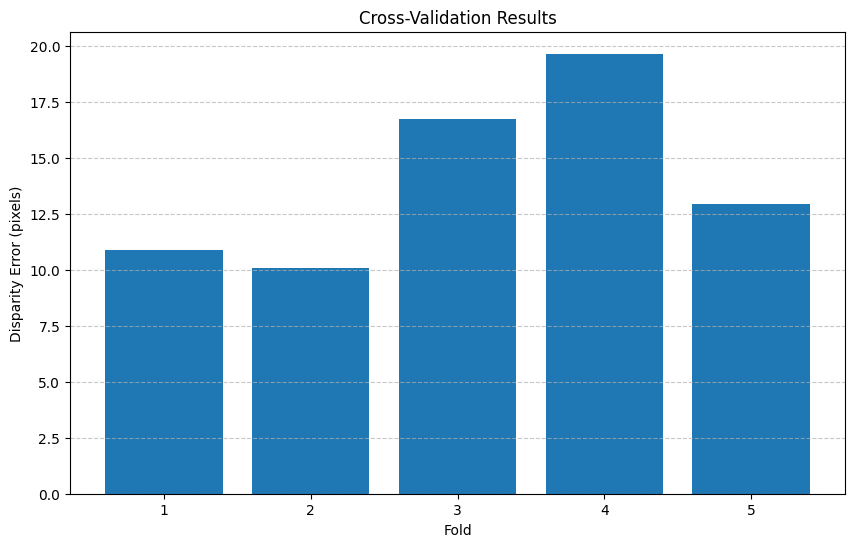


找到 3 个预测视差图:


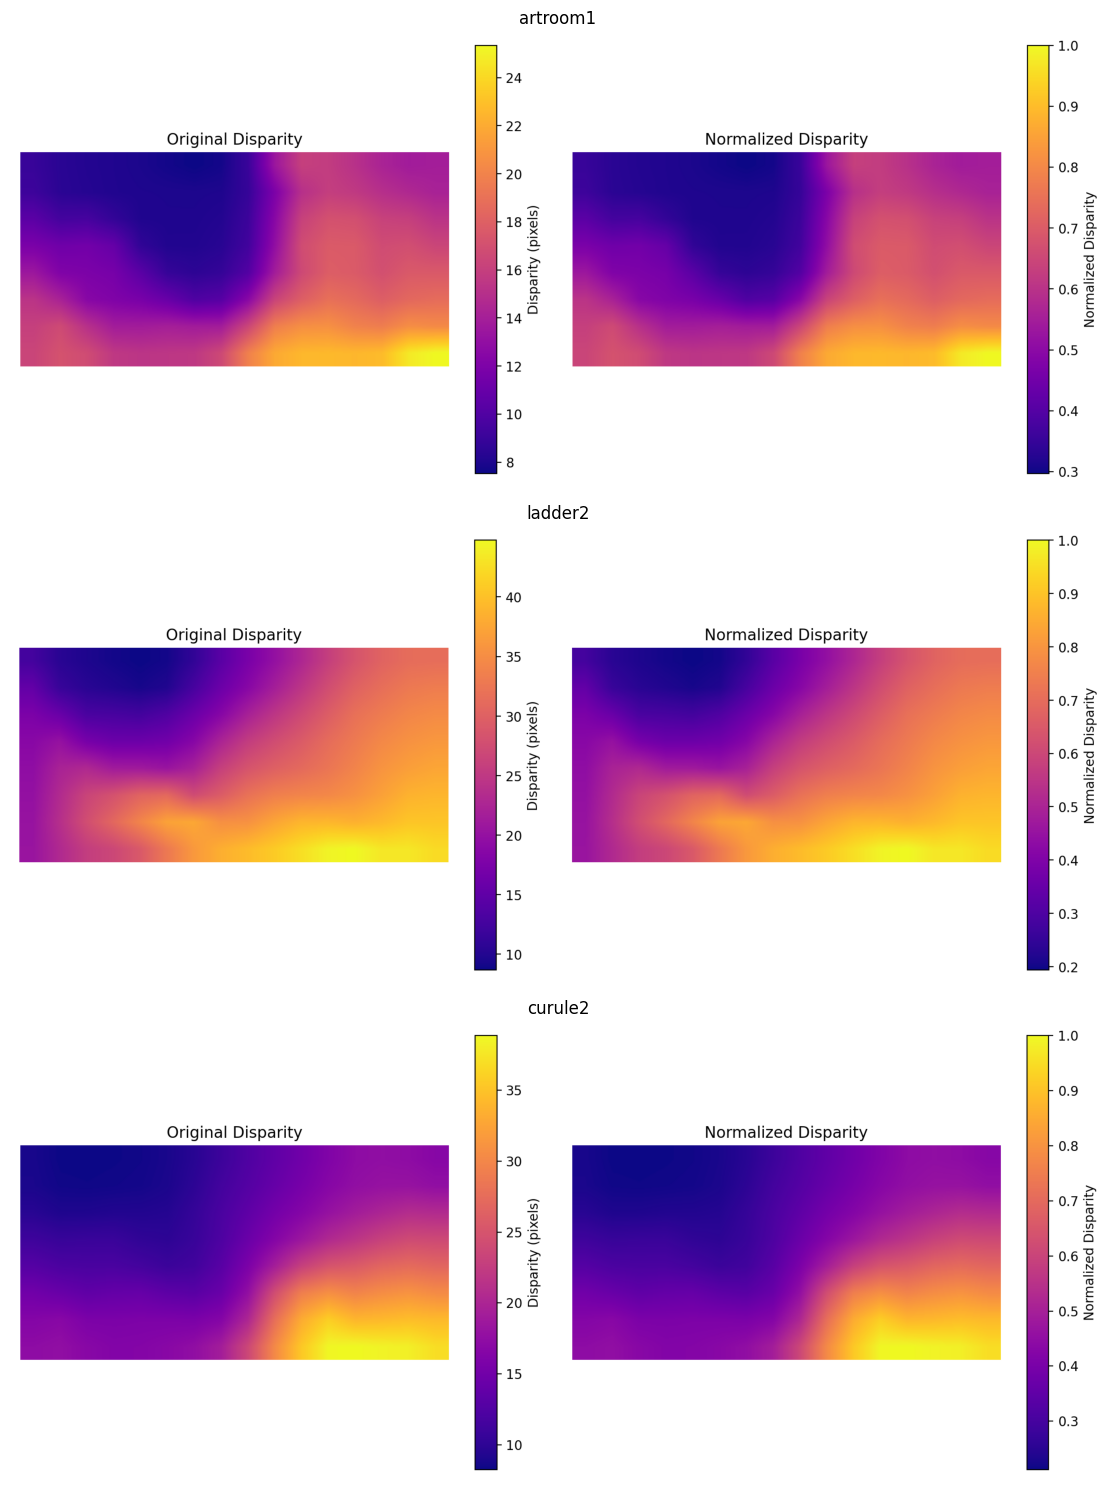

In [ ]:
def visualize_results():
    """Visualize training and validation results."""
    # Check if cross-validation results file exists
    cv_path = os.path.join(OUTPUT_DIR, 'ex4c_crossvalidation.csv')
    if os.path.exists(cv_path):
        # Load results
        cv_results = pd.read_csv(cv_path)
        print("Cross-validation results:")
        print(cv_results)
        
        # Compute mean error
        mean_error = cv_results['Disparity_Error'].mean()
        print(f"\nMean disparity error: {mean_error:.4f} pixels")
        
        # Plot error bar chart
        plt.figure(figsize=(10, 6))
        plt.bar(range(1, len(cv_results)+1), cv_results['Disparity_Error'])
        plt.xlabel('Fold')
        plt.ylabel('Disparity Error (pixels)')
        plt.title('Cross-Validation Results')
        plt.xticks(range(1, len(cv_results)+1))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.savefig(os.path.join(OUTPUT_DIR, 'disparity_errors.png'))
        plt.show()
    else:
        print("Cross-validation results file not found. Please run training first.")
    
    # Find and display disparity maps
    disp_files = [f for f in os.listdir(OUTPUT_DIR) if f.startswith('ex4b_') and f.endswith('_disparitymap.png')]
    if disp_files:
        print(f"\nFound {len(disp_files)} predicted disparity maps:")
        plt.figure(figsize=(15, 5*min(len(disp_files), 3)))
        
        for i, f in enumerate(disp_files[:3]):
            img = plt.imread(os.path.join(OUTPUT_DIR, f))
            plt.subplot(min(len(disp_files), 3), 1, i+1)
            plt.imshow(img)
            plt.title(f.replace('ex4b_', '').replace('_disparitymap.png', ''))
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No predicted disparity maps found. Please run training first.")

visualize_results()